In [83]:
# Imports for the project
import numpy as np
from scipy.io.wavfile import write
from datasets import load_dataset, DatasetDict
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [42]:
timit = DatasetDict()
timit["train"] = load_dataset("timit_asr", data_dir="timit", split="train")
timit["test"] = load_dataset("timit_asr", data_dir="timit", split="test")

timit

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id'],
        num_rows: 4620
    })
    test: Dataset({
        features: ['file', 'audio', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id'],
        num_rows: 1680
    })
})

### Display the entire Audio file as a spectrogram

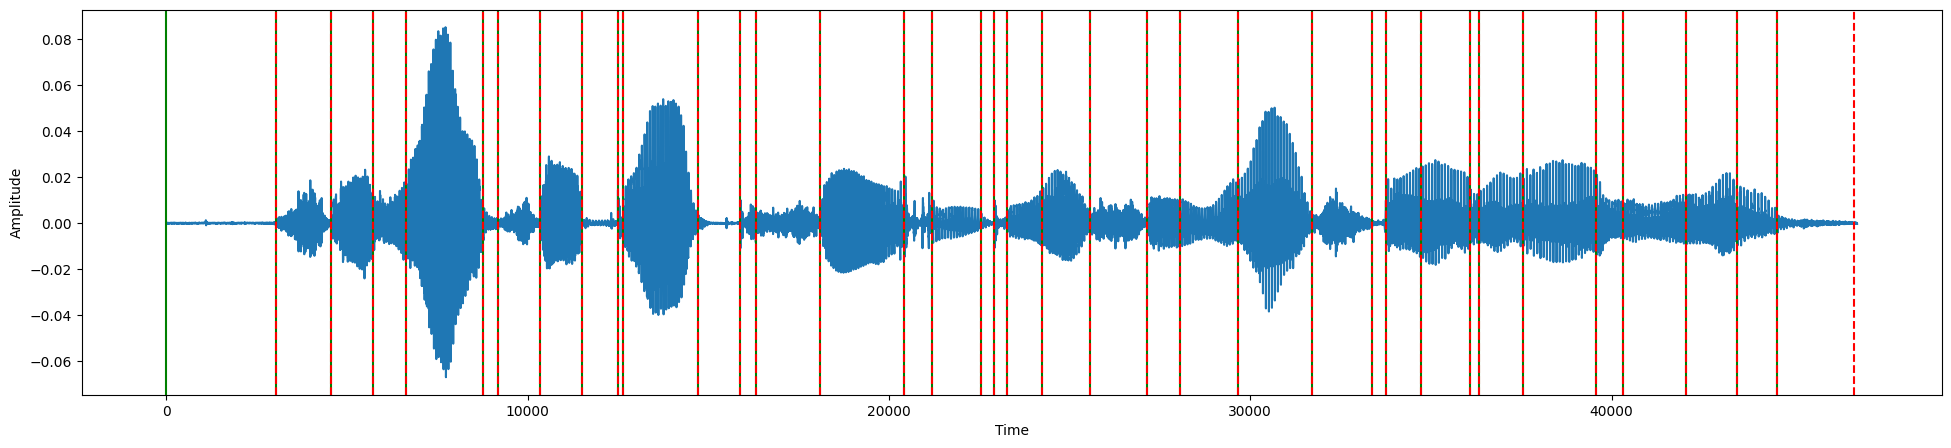

In [105]:

# Ensure sampling rate is 16kHz
audio_array = timit["train"][0]['audio']['array']
start_points = timit["train"][0]['phonetic_detail']['start']
stop_points = timit["train"][0]['phonetic_detail']['stop']
plt.figure(figsize=(24, 5))
plt.plot(audio_array)
plt.xlabel('Time')
plt.ylabel('Amplitude')


for x in start_points:
    plt.axvline(x=x, color='g', linestyle='-')

for x in stop_points:
    plt.axvline(x=x, color='r', linestyle='--')

plt.show()

We can see in the above plot that there are many regions in this audio file that correspond to the different phonemes (phonetic details, i.e. phonemes + pauses). Currently the lines split the phonemes with red indicating the end of a phoneme and green representing the beginning. It is clear just from looking at this that a lot of the phonemes could be divided up based on their amplitude. We will consider how the others might be divided up in the next section using their frequency content.

### Show part of the audio spectrogram and save it as a file

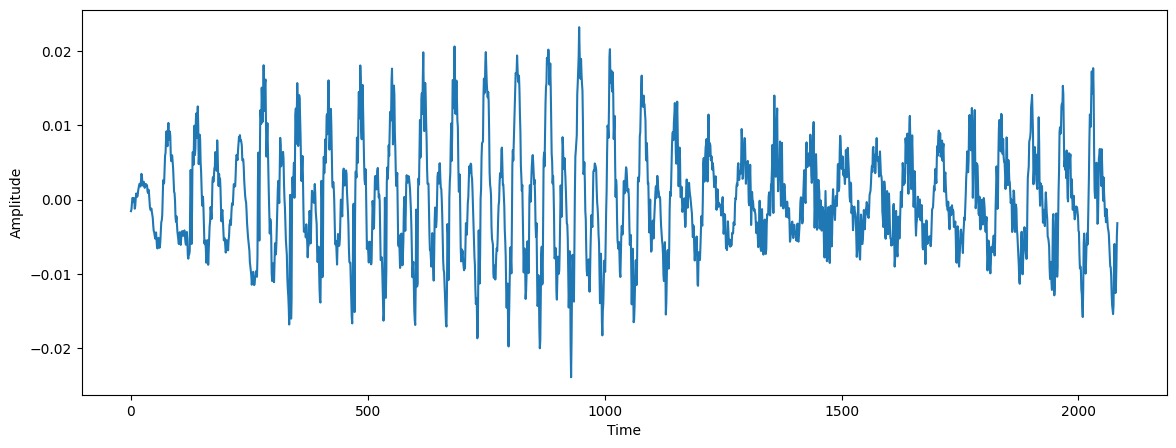

In [102]:
sample_rate = 16000
sub_audio_array = audio_array[start_points[2]:stop_points[3]]

# Save the array as a WAV file
write('output.wav', sample_rate, sub_audio_array)

plt.figure(figsize=(14, 5))
plt.plot(sub_audio_array)   # Plot the audio array between the start and stop points of the first phoneme
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

Saving this part of the file specifically allows us to listen to this audio and verify that it is a specific syllable. This is useful for debugging and verifying that the audio is being processed correctly.

### We now take the spectrogram and display the frequency components of the audio file.    

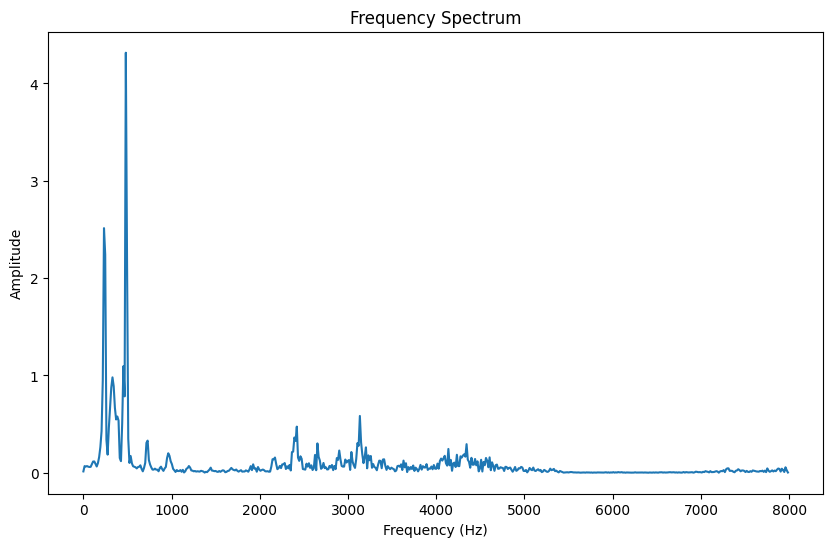

In [67]:
# Compute the fast fourier transform of the audio signal
fft_result = np.fft.fft(sub_audio_array)
fft_freq = np.fft.fftfreq(len(sub_audio_array), 1/sample_rate)

# Only keep positive 
positive_freqs = fft_freq[:len(fft_freq)//2]
positive_fft_result = np.abs(fft_result[:len(fft_result)//2])

# Plot the frequency spectrum
plt.figure(figsize=(10, 6))
plt.plot(positive_freqs, positive_fft_result)
plt.title('Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()

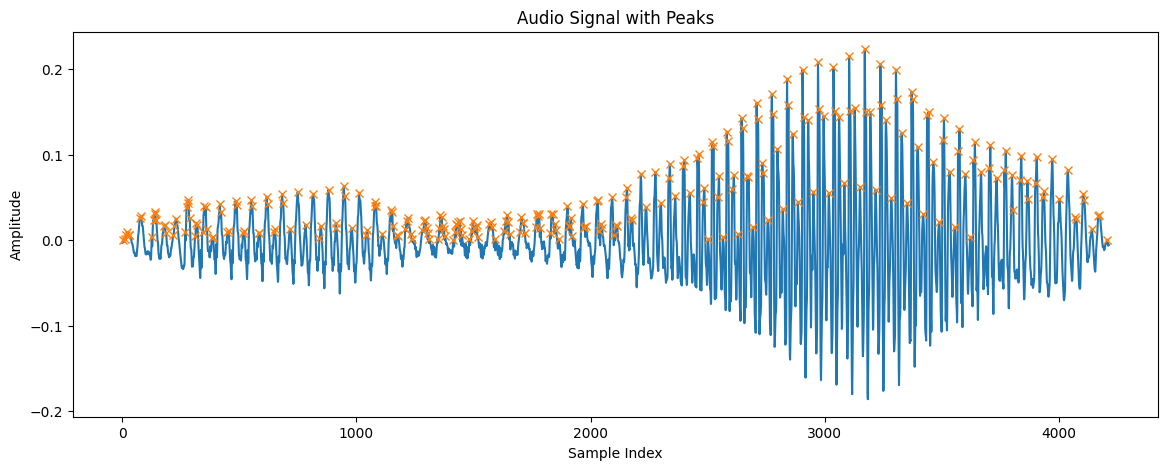

In [104]:
sub_audio_array = audio_array[start_points[2]:stop_points[4]]

# apply smoothing
sub_audio_array = np.convolve(sub_audio_array, np.ones(3), mode='same')

# Find peaks in the audio signal
peaks, _ = find_peaks(sub_audio_array, height=0)

# Plot the audio signal and mark the peaks
plt.figure(figsize=(14, 5))
plt.plot(sub_audio_array)
plt.plot(peaks, sub_audio_array[peaks], "x")

plt.title('Audio Signal with Peaks')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()


This shows how smoothing can help in locating peaks. The peaks are important as they help us to identify the frequency and hence the phoneme. The main issue here is that there are several overlapping frequencies in the same region, making it hard to calculate the exact frequency. 